Epoch 1/30
16/16 [==============================] - 2s 37ms/step - loss: 0.1195 - mse: 0.1195 - val_loss: 0.0738 - val_mse: 0.0738
Epoch 2/30
16/16 [==============================] - 0s 27ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 3/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0712 - mse: 0.0712 - val_loss: 0.0718 - val_mse: 0.0718
Epoch 4/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0697 - mse: 0.0697 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 5/30
16/16 [==============================] - 0s 26ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0678 - val_mse: 0.0678
Epoch 6/30
16/16 [==============================] - 0s 26ms/step - loss: 0.0644 - mse: 0.0644 - val_loss: 0.0627 - val_mse: 0.0627
Epoch 7/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0587 - mse: 0.0587 - val_loss: 0.0567 - val_mse: 0.0567
Epoch 8/30
16/16 [==============================] - 0s 24ms/step - loss: 0.0520 - m

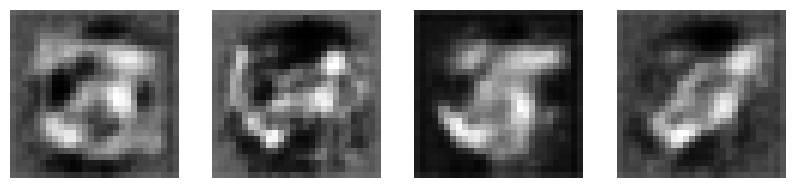

In [ ]:
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()

# Reduce the dataset to 50 images per category for training and 10 images per category for testing
num_train_images = 50
num_test_images = 10

# Function to reduce dataset
def reduce_dataset(images, num_images):
    reduced_dataset = np.zeros((num_images * 10, 28, 28), dtype=np.float32)
    for i in range(10):
        indices = np.where(_ == i)[0][:num_images]
        reduced_dataset[i*num_images:(i+1)*num_images] = images[indices]
    return reduced_dataset

x_train_reduced = reduce_dataset(x_train, num_train_images)
x_test_reduced = reduce_dataset(x_test, num_test_images)

# Shuffle both datasets
np.random.shuffle(x_train_reduced)
np.random.shuffle(x_test_reduced)

# Normalize input data to the range (0,1)
x_train_reduced = x_train_reduced / 255.0
x_test_reduced = x_test_reduced / 255.0

# Reshape data for Conv2D layers
x_train_reduced = np.expand_dims(x_train_reduced, axis=-1)
x_test_reduced = np.expand_dims(x_test_reduced, axis=-1)

# Autoencoder model
input_shape = (28, 28, 1)
latent_dim = 4

# Encoder
inputs = Input(shape=input_shape)
x = Conv2D(30, (3, 3), activation='relu', padding='same')(inputs)
x = Flatten()(x)
latent_space = Dense(latent_dim)(x)

# Decoder
decoder_inputs = Input(shape=(latent_dim,))
x = Dense(30 * 28 * 28, activation='relu')(decoder_inputs)
x = Reshape((28, 28, 30))(x)
x = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)

# Models
encoder = Model(inputs, latent_space, name='encoder')
decoder = Model(decoder_inputs, x, name='decoder')

# Autoencoder model
autoencoder = Model(inputs, decoder(encoder(inputs)), name='autoencoder')

# Compile model
autoencoder.compile(optimizer=Adam(learning_rate=0.004), loss='mse', metrics=['mse'])

# Train the model
epochs = 30
batch_size = 32

history = autoencoder.fit(
    x_train_reduced, x_train_reduced,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_reduced, x_test_reduced)
)

# Split the trained model into encoder and decoder
encoder = Model(inputs=inputs, outputs=latent_space)
latent_inputs = Input(shape=(latent_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=latent_inputs, outputs=decoder_layer(latent_inputs))

# Generate new images from decoder based on random values in latent space
num_generated_images = 4
random_values = np.random.normal(size=(num_generated_images, latent_dim))
generated_images = decoder.predict(random_values)

# Display generated images
plt.figure(figsize=(10, 4))
for i in range(num_generated_images):
    ax = plt.subplot(1, num_generated_images, i + 1)
    plt.imshow(generated_images[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.show()
